In [209]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# UWB Signal Processing Constants
ROI_START, ROI_END = 700, 820  # Region of Interest for CIR analysis (empirically determined peak region)
TS_DW1000 = 1 / (128 * 499.2e6)  # DW1000 time sample period: 15.65 ps per sample
C_AIR = 299_792_458.0  # Speed of light in air (m/s)

# FP_INDEX is a hardware register value that needs scaling by 64 to convert to CIR index
# This represents the First Path detection from the DW1000 chip
FP_INDEX_SCALE = 64.0

# Preferred scenario ordering for consistent visualization
PREFERRED_SCENARIOS = [
    "LOS 2 m living room",
    "LOS 4.3 m corner",
    "NLOS 1.56 m open door",
    "NLOS 4.4 m closed door",
]

## Configuration & Constants

## Load Data (merged or individual CSVs)

In [210]:
merge_path = Path('../dataset/merged_cir.csv')
if merge_path.exists():
    data = pd.read_csv(merge_path)
    print(f'Loaded merged file: {merge_path} -> {data.shape}')
else:
    files = [
        ('../dataset/LOS_2m_living_room_home.csv',        'LOS',  2.0,  'LOS 2 m living room'),
        ('../dataset/LOS_4.3m_living_room_corner_home.csv','LOS',  4.3, 'LOS 4.3 m corner'),
        ('../dataset/NLOS_1.56m_open_door_home.csv',       'NLOS', 1.56,'NLOS 1.56 m open door'),
        ('../dataset/NLOS_4.4m_close_door_home.csv',       'NLOS', 4.4, 'NLOS 4.4 m closed door'),
    ]
    frames = []
    for fname, label, d_true, scen in files:
        df = pd.read_csv(fname)
        df['label'] = label
        df['d_true'] = d_true
        df['scenario'] = scen
        frames.append(df)
    data = pd.concat(frames, ignore_index=True)
    print('Loaded individual CSVs ->', data.shape)

data.head()

Loaded merged file: ..\dataset\merged_cir.csv -> (4000, 1028)


,Capture_ID,Distance,FP_INDEX,FP_AMPL1,FP_AMPL2,FP_AMPL3,RXPACC,STD_NOISE,MAX_NOISE,CIR0,...,CIR1009,CIR1010,CIR1011,CIR1012,CIR1013,CIR1014,CIR1015,label,d_true,scenario
0,0,1.951188,47887,6794,7577,7081,118,64,1635,271,...,47,128,66,47,17,140,35,LOS,2.0,LOS 2 m living room
1,1,1.876143,48066,6564,7433,7098,118,60,1476,230,...,239,90,132,35,125,42,49,LOS,2.0,LOS 2 m living room
2,2,1.894904,47840,7071,7552,6047,118,48,1191,281,...,72,75,96,70,147,50,66,LOS,2.0,LOS 2 m living room
3,3,1.932427,47634,7102,7397,6927,118,56,1371,105,...,184,130,79,94,43,82,93,LOS,2.0,LOS 2 m living room
4,4,1.969950,47690,6727,7539,7420,118,56,1392,260,...,24,248,25,96,166,85,103,LOS,2.0,LOS 2 m living room


## Data Quality Check

In [211]:
# Check for missing values before proceeding with analysis
print('Shape:', data.shape)
print('\nMissing values (top 10):')
missing = data.isna().sum().sort_values(ascending=False).head(10)
if missing.max() > 0:
    print(missing)
    print('\n⚠ Warning: Missing values detected. May affect feature engineering.')
else:
    print('✓ No missing values detected.')

Shape: (4000, 1028)

Missing values (top 10):
✓ No missing values detected.


In [222]:
# Basic overview
print('Label counts:')
print(data['label'].value_counts())
print('\nScenario counts:')
print(data['scenario'].value_counts())
print('\nTrue distances:')
print(data.groupby('scenario')['d_true'].first().sort_values())

Label counts:
label
LOS     2000
NLOS    2000
Name: count, dtype: int64

Scenario counts:
scenario
LOS 2 m living room       1000
LOS 4.3 m corner          1000
NLOS 1.56 m open door     1000
NLOS 4.4 m closed door    1000
Name: count, dtype: int64

True distances:
scenario
NLOS 1.56 m open door     1.56
LOS 2 m living room       2.00
LOS 4.3 m corner          4.30
NLOS 4.4 m closed door    4.40
Name: d_true, dtype: float64


## Dataset Overview (labels, scenarios, distributions)

## Feature Engineering

Create derived features for analysis:
- **ROI energy**: Signal energy in the region of interest (700-820 index range)
- **FP_INDEX_scaled**: Hardware first-path index converted to CIR index units (divided by 64)
- **True_Index**: Expected CIR index based on true distance and time-of-flight
- **Index errors**: Differences between hardware, detected peak, and true indices

In [213]:
# Extract CIR column names and sort numerically
cir_cols = [c for c in data.columns if c.startswith('CIR') and c[3:].isdigit()]
cir_cols.sort(key=lambda x: int(x[3:]))

# Calculate distance error
data['dist_error'] = data['Distance'] - data['d_true']

# ROI energy (sum of squared amplitudes in region of interest)
roi_cols = [f'CIR{i}' for i in range(ROI_START, ROI_END + 1)]
data['roi_energy'] = (data[roi_cols].values ** 2).sum(axis=1)

# Convert hardware FP_INDEX to CIR index scale
data['FP_INDEX_scaled'] = data['FP_INDEX'] / FP_INDEX_SCALE
data['ToF_true_s'] = data['d_true'] / C_AIR
data['True_Index'] = np.round(data['ToF_true_s'] / TS_DW1000).astype(int)
data['Max_Index'] = data[cir_cols].idxmax(axis=1).str.replace('CIR', '').astype(int)

data['Index_Error_FP_vs_true'] = data['FP_INDEX_scaled'] - data['True_Index']
data['Index_Error_peak_vs_true'] = data['Max_Index'] - data['True_Index']

data[['dist_error', 'roi_energy', 'FP_INDEX_scaled', 'True_Index', 'Max_Index']].head()

,dist_error,roi_energy,FP_INDEX_scaled,True_Index,Max_Index
0,-0.048812,287621771,748.234375,426,750
1,-0.123857,262886261,751.031250,426,753
2,-0.105096,256016221,747.500000,426,749
3,-0.067573,276303564,744.281250,426,746
4,-0.030050,275948812,745.156250,426,747


## Distributions (energy/error/index) by label


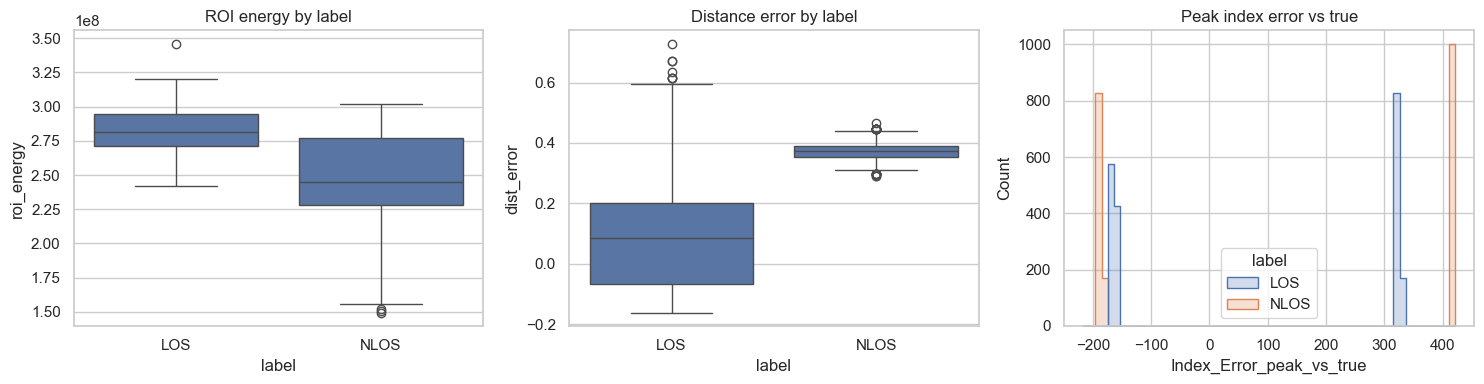

In [214]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.boxplot(data=data, x='label', y='roi_energy', ax=axes[0])
axes[0].set_title('ROI energy by label')
sns.boxplot(data=data, x='label', y='dist_error', ax=axes[1])
axes[1].set_title('Distance error by label')
sns.histplot(data=data, x='Index_Error_peak_vs_true', hue='label', bins=60, element='step', ax=axes[2])
axes[2].set_title('Peak index error vs true')
plt.tight_layout()
plt.show()

## Mean CIR in ROI by label


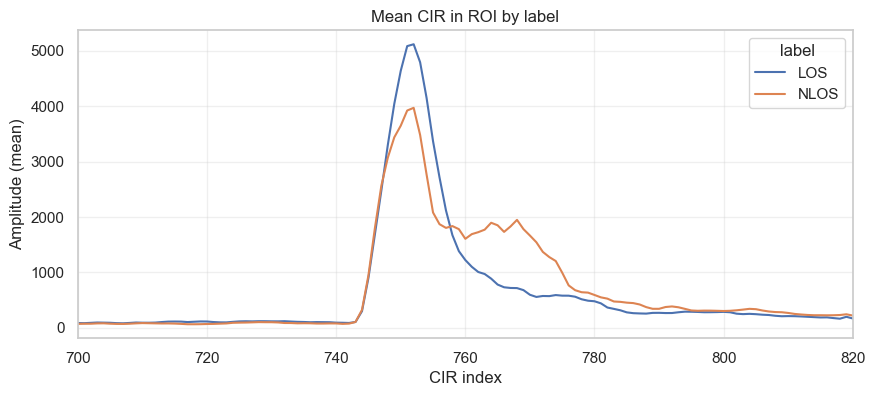

In [215]:
plot_df = data.groupby('label')[roi_cols].mean().T
plot_df.index = plot_df.index.str.replace('CIR', '').astype(int)
plot_df.plot(figsize=(10, 4))
plt.title('Mean CIR in ROI by label')
plt.xlabel('CIR index')
plt.ylabel('Amplitude (mean)')
plt.grid(alpha=0.3)
plt.xlim(ROI_START, ROI_END)
plt.show()


## Multipath Extraction (peaks, first path/bounce)

Extract multipath components from CIR signals:
- Detect peaks above noise threshold (5x median noise floor)
- Identify first path (earliest significant peak near hardware FP_INDEX)
- Find first bounce (next significant peak after first path)
- Calculate delay between first path and first bounce in nanoseconds

In [216]:
def simple_peaks(wave, threshold, min_gap=3):
    """Detect local peaks in waveform above threshold with minimum separation."""
    peaks = []
    for i in range(1, len(wave) - 1):
        if wave[i] >= threshold and wave[i] >= wave[i - 1] and wave[i] >= wave[i + 1]:
            if peaks and (i - peaks[-1] < min_gap):
                if wave[i] > wave[peaks[-1]]:
                    peaks[-1] = i
            else:
                peaks.append(i)
    return np.array(peaks, dtype=int)

def extract_multipath(row, start=650, end=900):
    """Extract multipath features from a single CIR measurement."""
    wf = row[cir_cols].values.astype(float)
    end_idx = min(end, len(wf) - 1)
    roi = np.abs(wf[start:end_idx + 1])
    noise_floor = np.median(np.abs(wf[0:600]))
    threshold = noise_floor * 5
    local_peaks = simple_peaks(roi, threshold=threshold, min_gap=2)
    peaks_abs = local_peaks + start
    if len(peaks_abs) == 0:
        return pd.Series({
            'fp_peak_idx': np.nan,
            'fp_peak_amp': np.nan,
            'first_bounce_idx': np.nan,
            'first_bounce_delay_ns': np.nan,
            'multipath_count': 0,
        })

    fp_hw_idx = row['FP_INDEX'] / FP_INDEX_SCALE
    near_fp = [p for p in peaks_abs if p >= fp_hw_idx - 5]
    fp_peak_idx = min(near_fp) if near_fp else peaks_abs.min()
    fp_peak_amp = float(np.abs(wf[int(fp_peak_idx)]))

    later = [p for p in peaks_abs if p > fp_peak_idx + 5]
    first_bounce_idx = min(later) if later else np.nan
    first_bounce_delay_ns = ((first_bounce_idx - fp_peak_idx) * TS_DW1000 * 1e9
                             if not np.isnan(first_bounce_idx) else np.nan)

    return pd.Series({
        'fp_peak_idx': fp_peak_idx,
        'fp_peak_amp': fp_peak_amp,
        'first_bounce_idx': first_bounce_idx,
        'first_bounce_delay_ns': first_bounce_delay_ns,
        'multipath_count': len(peaks_abs),
    })

mp = data.apply(extract_multipath, axis=1)
data = pd.concat([data, mp], axis=1)

data[['fp_peak_idx', 'first_bounce_idx', 'first_bounce_delay_ns', 'multipath_count']].head()

,fp_peak_idx,first_bounce_idx,first_bounce_delay_ns,multipath_count
0,750.0,756.0,0.09390,9.0
1,753.0,760.0,0.10955,13.0
2,749.0,757.0,0.12520,13.0
3,746.0,753.0,0.10955,12.0
4,747.0,754.0,0.10955,16.0


## Multipath Summary (bounce delay, counts)


Mean first-bounce delay (ns) by label:
label
LOS     0.113017
NLOS    0.131969
Name: first_bounce_delay_ns, dtype: float64

Multipath count by label (mean):
label
LOS     13.6025
NLOS    17.3825
Name: multipath_count, dtype: float64


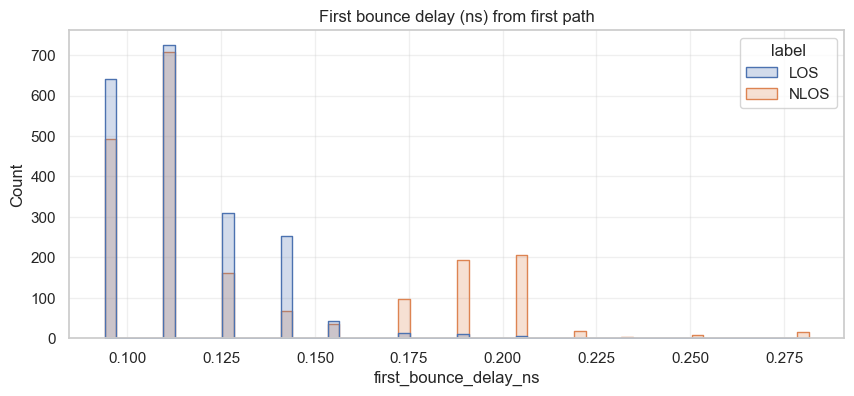

In [223]:
print('Mean first-bounce delay (ns) by label:')
print(data.groupby('label')['first_bounce_delay_ns'].mean())

print('\nMultipath count by label (mean):')
print(data.groupby('label')['multipath_count'].mean())

plt.figure(figsize=(10, 4))
sns.histplot(data=data, x='first_bounce_delay_ns', hue='label', bins=60, element='step', kde=False)
plt.title('First bounce delay (ns) from first path')
plt.grid(alpha=0.3)
plt.show()


## Sample Visualization with Peaks


Visualization window: 740..790


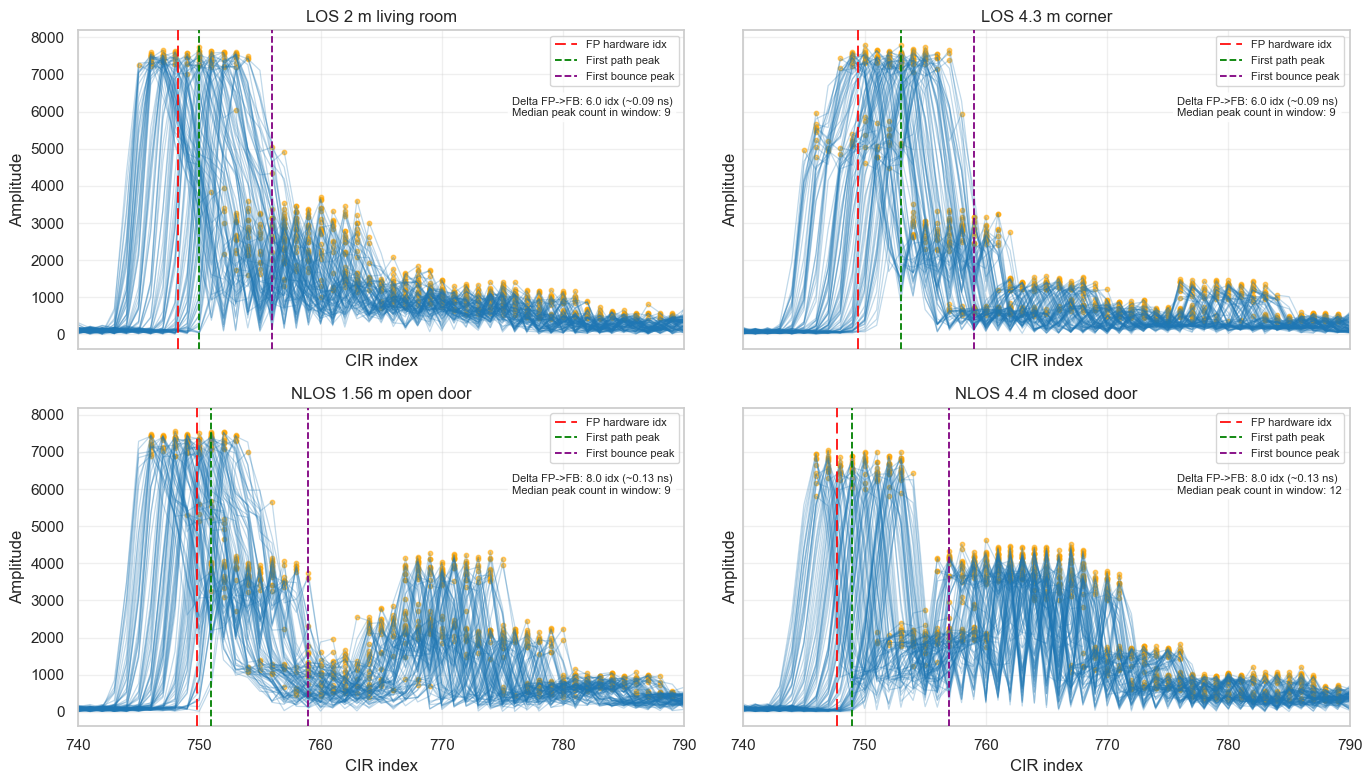

In [218]:
start, end = 740, 790
print(f"Visualization window: {start}..{end}")

# Use centralized scenario preferences
scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)
plot_scenarios = plot_scenarios[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ax, scen in zip(axes, plot_scenarios):
    rows = data[data["scenario"] == scen].head(100)
    if rows.empty:
        ax.axis("off")
        continue
    first_row = rows.iloc[0]
    # x-axis now represents actual CIR indices in the window
    x = np.arange(start, end + 1)
    peak_counts = []
    # overlay many samples with translucent lines
    for _, row in rows.iterrows():
        wf = row[cir_cols].values.astype(float)
        noise_floor = np.median(np.abs(wf[0:600]))
        threshold = noise_floor * 5
        peaks = simple_peaks(np.abs(wf[start:end + 1]), threshold=threshold, min_gap=2) + start
        peak_counts.append(len(peaks))
        # Plot only the windowed portion [start:end+1]
        ax.plot(x, wf[start:end + 1], color="#1f77b4", alpha=0.28, lw=0.9)
        ax.scatter(peaks, wf[peaks], color="orange", s=10, alpha=0.55)

    # annotate with reference lines from the first sample of this scenario
    fp_hw = first_row.get("FP_INDEX", np.nan) / FP_INDEX_SCALE
    fp_peak_idx = first_row.get("fp_peak_idx", np.nan)
    fb_idx = first_row.get("first_bounce_idx", np.nan)
    handles = []
    labels = []
    if not np.isnan(fp_hw):
        fp_line_x = fp_hw
        # If FP hardware and detected peak nearly coincide, nudge hardware left so it remains visible
        if not np.isnan(fp_peak_idx) and abs(fp_hw - fp_peak_idx) < 1.0:
            fp_line_x = fp_hw - 1.0
        h = ax.axvline(fp_line_x, color="red", ls=(0, (6, 3)), lw=1.3, alpha=0.95, zorder=7)
        handles.append(h); labels.append("FP hardware idx")
    if not np.isnan(fp_peak_idx):
        h = ax.axvline(fp_peak_idx, color="green", ls="--", lw=1.3, zorder=6)
        handles.append(h); labels.append("First path peak")
    if not np.isnan(fb_idx):
        h = ax.axvline(fb_idx, color="purple", ls="--", lw=1.3, zorder=6)
        handles.append(h); labels.append("First bounce peak")

    ax.set_xlim(start, end)
    ax.set_title(scen)
    ax.grid(alpha=0.3)
    ax.set_xlabel("CIR index")
    ax.set_ylabel("Amplitude")
    legend = None
    if handles:
        legend = ax.legend(handles, labels, loc="upper right", fontsize=8)

    # text annotation: path-to-bounce gap and typical multipath count
    lines_text = []
    if not np.isnan(fp_peak_idx) and not np.isnan(fb_idx):
        gap_idx = fb_idx - fp_peak_idx
        gap_ns = gap_idx * TS_DW1000 * 1e9  # convert to ns
        lines_text.append(f"Delta FP->FB: {gap_idx:.1f} idx (~{gap_ns:.2f} ns)")
    if peak_counts:
        lines_text.append(f"Median peak count in window: {np.median(peak_counts):.0f}")
    if lines_text:
        # align with legend: place just below and slightly left
        ann_x, ann_y = 0.70, 0.70  # default if no legend
        if legend is not None:
            fig.canvas.draw()
            renderer = fig.canvas.get_renderer()
            bbox = legend.get_window_extent(renderer=renderer)
            bbox_axes = bbox.transformed(ax.transAxes.inverted())
            width = bbox_axes.x1 - bbox_axes.x0
            ann_x = bbox_axes.x0 - 0.05 * width  # shift a bit left of legend
            ann_y = bbox_axes.y0 - 0.05 * (bbox_axes.y1 - bbox_axes.y0)
        ax.text(ann_x, ann_y, "\n".join(lines_text), fontsize=8,
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.85),
                va="top", ha="left", transform=ax.transAxes)

# turn off any unused axes
for ax in axes[len(plot_scenarios):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Raw CIR comparison (per scenario)


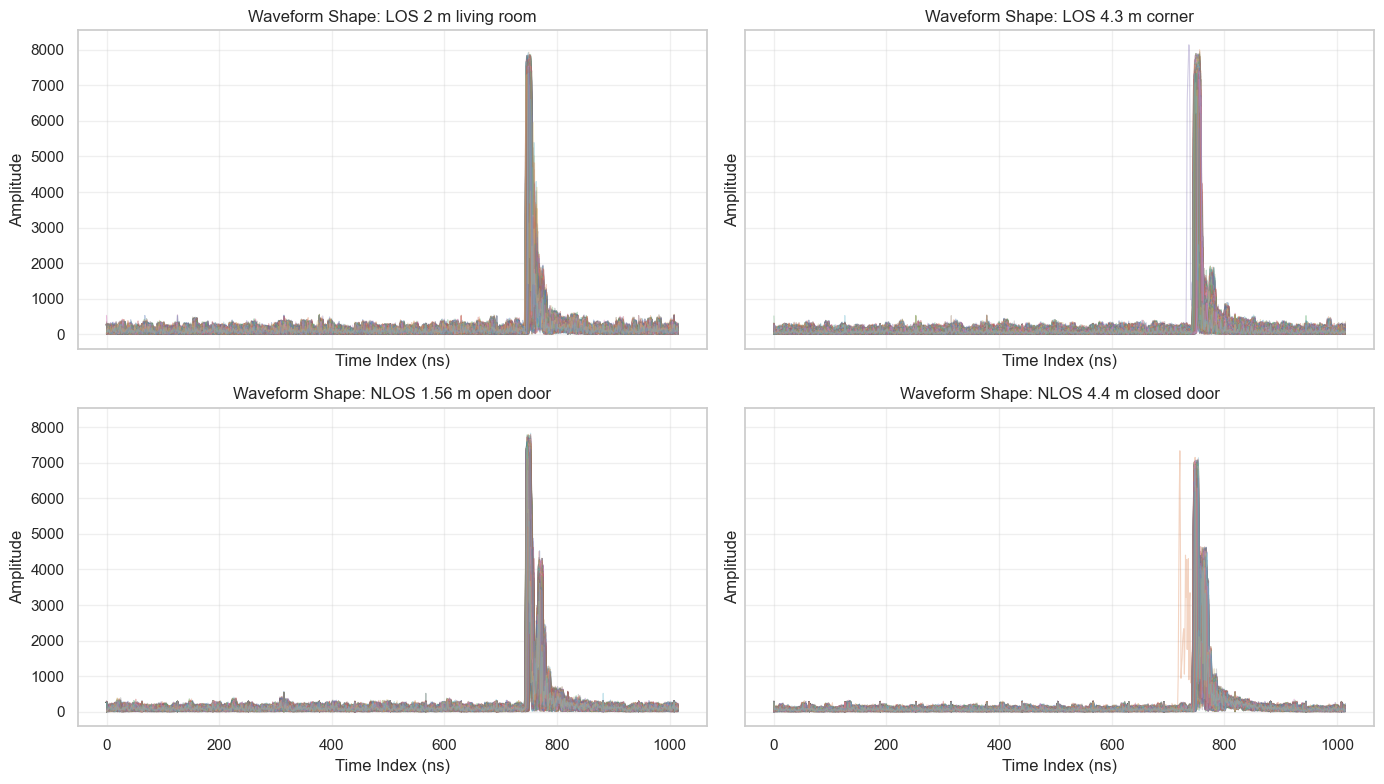

In [219]:
# Raw CIR comparison (up to 1000 samples per scenario)
scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)
plot_scenarios = plot_scenarios[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ax, scen in zip(axes, plot_scenarios):
    rows = data.loc[data["scenario"] == scen].head(1000)  # adjust here for more/less per scenario
    for _, row in rows.iterrows():
        wf = row[cir_cols].values.astype(float)
        x = np.arange(len(wf))
        ax.plot(x, wf, lw=0.8, alpha=0.35)
    ax.set_title(f"Waveform Shape: {scen}")
    ax.set_xlabel("Time Index (ns)")
    ax.set_ylabel("Amplitude")
    ax.grid(alpha=0.3)
for ax in axes[len(plot_scenarios):]:
    ax.axis("off")
plt.tight_layout()
plt.show()

## Signal Stability (mean +/- std) and peak index


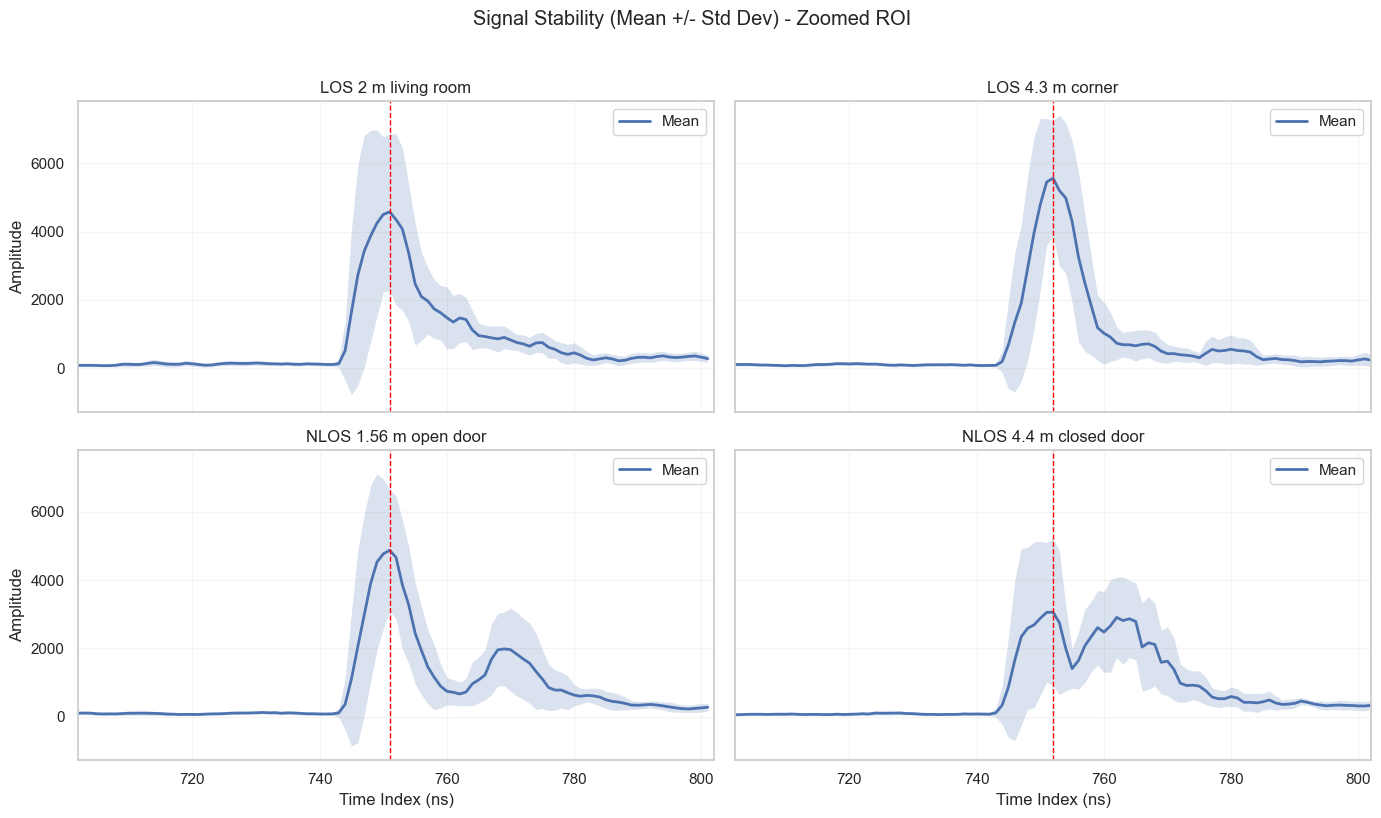

,scenario,peak_idx,peak_amp
0,LOS 2 m living room,751,4576.01
2,NLOS 1.56 m open door,751,4876.32
1,LOS 4.3 m corner,752,5564.93
3,NLOS 4.4 m closed door,752,3064.20


In [220]:
# Signal stability (mean +/- std) and peak index per scenario (zoomed ROI)
sns.set_theme(style="whitegrid")

scenarios_all = list(data["scenario"].unique())
plot_scenarios = [s for s in PREFERRED_SCENARIOS if s in scenarios_all]
for s in scenarios_all:
    if s not in plot_scenarios:
        plot_scenarios.append(s)
plot_scenarios = plot_scenarios[:4]

results = []
zoom_half = 50  # half-width of zoom window around the peak
color = sns.color_palette("deep")[0]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ax, scen in zip(axes, plot_scenarios):
    rows = data.loc[data["scenario"] == scen].head(100)
    if rows.empty:
        ax.axis("off")
        continue
    wf_stack = rows[cir_cols].values.astype(float)
    mean_wf = wf_stack.mean(axis=0)
    std_wf = wf_stack.std(axis=0)
    x = np.arange(mean_wf.shape[0])
    peak_idx = int(np.argmax(mean_wf))
    peak_amp = float(mean_wf[peak_idx])
    results.append({"scenario": scen, "peak_idx": peak_idx, "peak_amp": peak_amp})

    z0 = max(0, peak_idx - zoom_half)
    z1 = min(len(x) - 1, peak_idx + zoom_half)
    lower = mean_wf - std_wf
    upper = mean_wf + std_wf

    ax.fill_between(x[z0:z1 + 1], lower[z0:z1 + 1], upper[z0:z1 + 1],
                    color=color, alpha=0.2, linewidth=0)
    sns.lineplot(x=x[z0:z1 + 1], y=mean_wf[z0:z1 + 1], ax=ax, color=color, lw=2, label="Mean")
    ax.axvline(peak_idx, color="red", ls="--", lw=1, label="Peak index")

    ax.set_xlim(z0, z1)
    ax.set_title(scen)
    ax.set_xlabel("Time Index (ns)")
    ax.set_ylabel("Amplitude")
    ax.grid(alpha=0.2)

for ax in axes[len(plot_scenarios):]:
    ax.axis("off")

fig.suptitle("Signal Stability (Mean +/- Std Dev) - Zoomed ROI", y=1.02)
plt.tight_layout()
plt.show()

pd.DataFrame(results).sort_values("peak_idx")

## Baseline LOS/NLOS Classifier

Simple logistic regression model to classify LOS vs NLOS conditions.

**Features used:**
- `roi_energy`: Signal energy in region of interest
- `fp_peak_amp`: Amplitude of first path peak
- `first_bounce_delay_ns`: Time delay to first multipath bounce
- `multipath_count`: Number of detected multipath components
- `FP_INDEX_scaled`: Hardware-detected first path index
- `Max_Index`: Index of maximum CIR amplitude

**Interpretation:**
- Higher coefficients indicate stronger discriminative power
- Positive coefficients correlate with NLOS classification
- Confusion matrix shows prediction accuracy (rows=actual, cols=predicted)

In [224]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

feat_cols = ['roi_energy', 'fp_peak_amp', 'first_bounce_delay_ns', 'multipath_count', 'FP_INDEX_scaled', 'Max_Index']
df = data.dropna(subset=feat_cols).copy()
X = df[feat_cols].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf = make_pipeline(StandardScaler(), LogisticRegression(max_iter=200))
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Confusion matrix (rows=true, cols=pred):')
print(confusion_matrix(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred, digits=3))

print('\nFeature importance (coefficient magnitude):')
coef = clf.named_steps['logisticregression'].coef_[0]
for name, c in sorted(zip(feat_cols, coef), key=lambda t: abs(t[1]), reverse=True):
    print(f"{name:25s}: {c:+.3f}")

Confusion matrix (rows=true, cols=pred):
[[353  47]
 [ 59 341]]

Classification report:
              precision    recall  f1-score   support

         LOS      0.857     0.882     0.869       400
        NLOS      0.879     0.853     0.865       400

    accuracy                          0.868       800
   macro avg      0.868     0.867     0.867       800
weighted avg      0.868     0.868     0.867       800


Feature importance (coefficient magnitude):
Max_Index                : -6.750
FP_INDEX_scaled          : +6.092
first_bounce_delay_ns    : +1.658
fp_peak_amp              : -1.258
multipath_count          : +1.251
roi_energy               : -0.786
